In [ ]:
%pip install tableone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00


In [ ]:

from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from tableone import TableOne
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
data = pd.read_csv('sampled_infant_mortality_data_imputed_m1.csv')

In [ ]:
data['T'].value_counts()

,count
T,
1.0,95733
0.0,27625


In [ ]:
T = data['T']
y = data['Y']
X = data.drop(columns=['T', 'Y'])

In [ ]:
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

In [ ]:
propensity_model = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
propensity_model.fit(X_train, T_train)
T_prob_train = propensity_model.predict_proba(X_train)[:,1]
T_prob_test = propensity_model.predict_proba(X_test)[:,1]

In [ ]:
brier_score = brier_score_loss(T_test, T_prob_test)
print(f'Brier Score: {brier_score}')

Brier Score: 0.1385622181461416


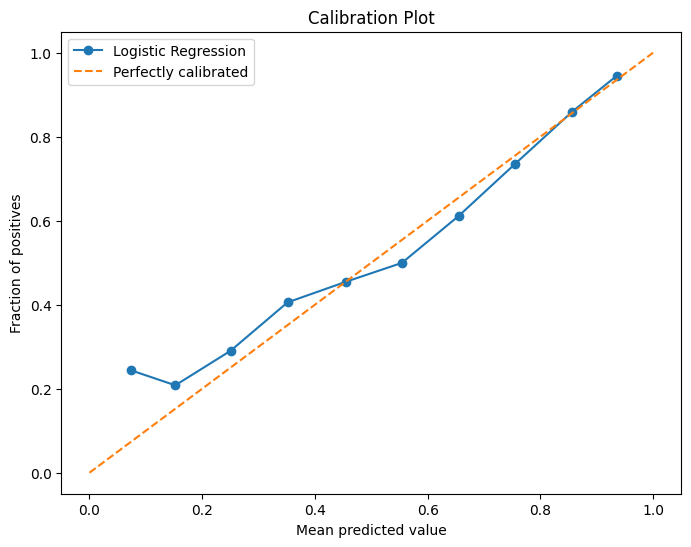

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, T_prob_test, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

Check overlap (positivity) on train set

Trim data to ensure overlap (set trimming boundaries on train set to avoid data leakage)

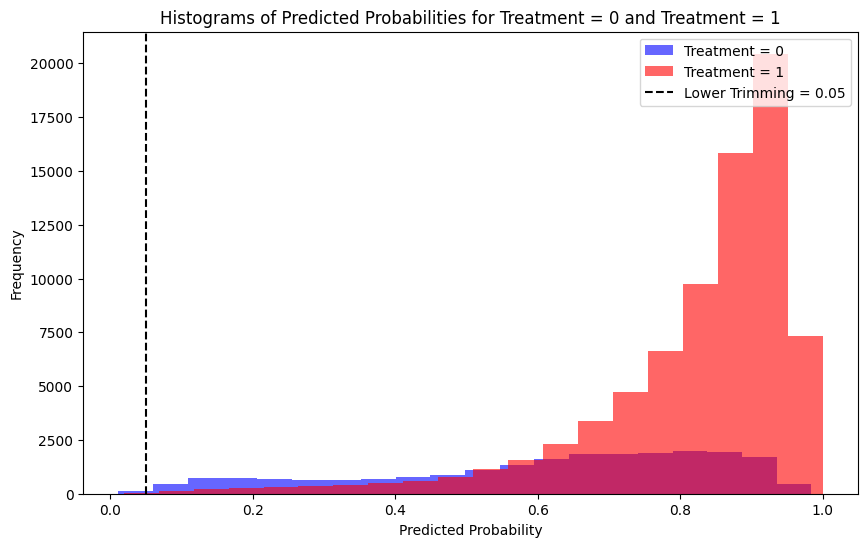

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(prob_treatment_0, bins=20, alpha=0.6, label='Treatment = 0', color='blue')
plt.hist(prob_treatment_1, bins=20, alpha=0.6, label='Treatment = 1', color='red')
plt.axvline(x=0.01, color='black', linestyle='--', label='Lower Trimming = 0.01')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histograms of Predicted Probabilities for Treatment = 0 and Treatment = 1')
plt.legend(loc='upper right')

plt.show()

we exclude participants whose estimated probability of being included in treatment is too low

In [ ]:
print('Participants removed from train set due to lack of overlap: {}'.format(X_train[(0.01 > T_prob_train) | (T_prob_train > 0.99)].shape[0]))
print('Participants removed from test set due to lack of overlap: {}'.format(X_test[(0.01 > T_prob_test) | (T_prob_test > 0.99)].shape[0]))

Participants removed from train set due to lack of overlap: 1622
Participants removed from test set due to lack of overlap: 418


In [ ]:
X_train = X_train[(0.01 <= T_prob_train) & (T_prob_train <= 0.99)]
T_train = T_train[(0.01 <= T_prob_train) & (T_prob_train <= 0.99)]
y_train = y_train[(0.01 <= T_prob_train) & (T_prob_train <= 0.99)]
X_test = X_test[(0.01 <= T_prob_test) & (T_prob_test <= 0.99)]
T_test = T_test[(0.01 <= T_prob_test) & (T_prob_test <= 0.99)]
y_test = y_test[(0.01 <= T_prob_test) & (T_prob_test <= 0.99)]

propensity_train_data = pd.concat([X_train, T_train, y_train], axis=1)
propensity_test_data = pd.concat([X_test, T_test, y_test], axis=1)

## Matching

In [ ]:
trimmed_data = pd.concat([propensity_train_data, propensity_test_data])

In [ ]:
trimmed_data.head()

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9,T,Y
117149,0.423319,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,1.0,0
7475,1.210909,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,0.0,1
46373,-1.151859,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,1.0,0
54802,0.895873,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,1.0,0
34390,-0.206752,-0.101463,-0.233133,-0.139689,-0.24412,-0.056821,-0.194308,-0.139598,-0.092832,0.084375,...,-0.006974,-0.129577,-0.163819,-0.166461,-0.028908,-0.008542,-0.004027,0.275476,0.0,0


We will look at a pre-matching comparison of the two treatment/intervention groups \
First using what is called a "Table1" because it is usually the first table in medical studies \
Secondly, standardized mean differences can be used to compare variables of different scales. The convention for "acceptable" difference is below 0.1. This is arbitrary like p-values needing to be below 0.05.

In [ ]:
all_cols = list(X.columns)
table2 = TableOne(trimmed_data, columns=all_cols, groupby='T', nonnormal=[], pval=False, smd=True)
print(table2.tabulate(tablefmt="fancy_grid"))

╒══════════════════════╤═════════════════════════╤═══════════╤════════════════╤═══════════════╤═══════════════╤═════════════════╕
│                      │                         │ Missing   │ Overall        │ 0.0           │ 1.0           │ SMD (0.0,1.0)   │
╞══════════════════════╪═════════════════════════╪═══════════╪════════════════╪═══════════════╪═══════════════╪═════════════════╡
│ n                    │                         │           │ 121318         │ 27625         │ 93693         │                 │
├──────────────────────┼─────────────────────────┼───────────┼────────────────┼───────────────┼───────────────┼─────────────────┤
│ FAGECOMB, n (%)      │ -0.04923410758815052    │           │ 6215 (5.1)     │ 1113 (4.0)    │ 5102 (5.4)    │ 0.463           │
├──────────────────────┼─────────────────────────┼───────────┼────────────────┼───────────────┼───────────────┼─────────────────┤
│                      │ -0.2067519516012383     │           │ 6208 (5.1)     │ 1080 (3.9)

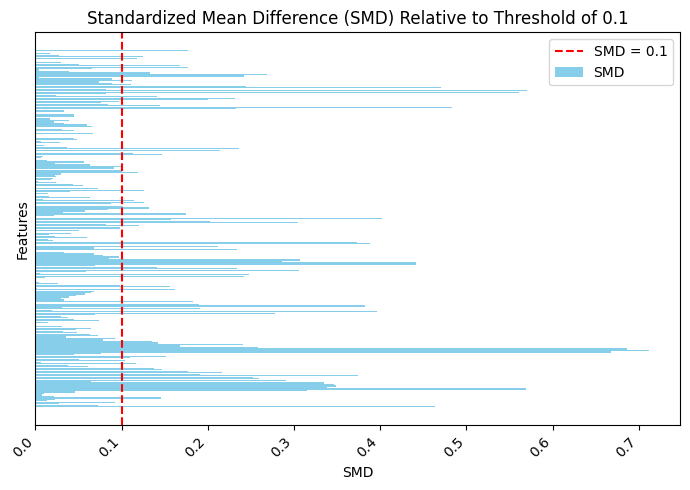

In [ ]:
plt.figure(figsize=(7, 5))

plt.barh(table2.smd_table.index, abs(table2.smd_table.values).flatten(), color='skyblue', label='SMD')

# SMD <= 0.1 is the convention for acceptable, like p-value <= 0.05
plt.axvline(x=0.1, color='r', linestyle='--', label='SMD = 0.1')
plt.xlabel('SMD')
plt.ylabel('Features')
plt.yticks([])
plt.title('Standardized Mean Difference (SMD) Relative to Threshold of 0.1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Moving on to matching

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [ ]:
standard_scaler = StandardScaler().fit(trimmed_data[X.columns])
standardized_data = deepcopy(trimmed_data)
standardized_data[X.columns] = standard_scaler.transform(standardized_data[X.columns])
standardized_data_treat1 = standardized_data.query('T == 1').reset_index().drop(columns=['index'])
standardized_data_treat0 = standardized_data.query('T == 0').reset_index().drop(columns=['index'])

In [ ]:
standardized_data_treat1.head()

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9,T,Y
0,0.423082,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0
1,-1.151673,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0
2,0.895508,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0
3,-0.000124,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,7.714277,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,-3.633228,1.0,0
4,-1.624099,-0.101218,4.288297,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.129630,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,1.0,0


In [ ]:
confounders = X.columns

In [ ]:
nn = NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=1)
distance, standardized_data_treat1['matched_treat0'] = nn.fit(standardized_data_treat0[confounders]).kneighbors(standardized_data_treat1[confounders])
matched_data = standardized_data_treat1.merge(standardized_data_treat0, left_on='matched_treat0', right_index=True, how='left', suffixes=('_treat1', '_treat0'))

In [ ]:
matched_data.head()

,FAGECOMB_treat1,RF_PDIAB_treat1,RF_GDIAB_treat1,RF_PHYPE_treat1,RF_GHYPE_treat1,RF_EHYPE_treat1,RF_PPB_treat1,RF_INFT_treat1,RF_DRG_treat1,RF_ART_treat1,...,DPLURAL_5_treat0,SETORDER_R_ _treat0,SETORDER_R_1_treat0,SETORDER_R_2_treat0,SETORDER_R_3_treat0,SETORDER_R_4_treat0,SETORDER_R_5_treat0,SETORDER_R_9_treat0,T_treat0,Y_treat0
0,0.423082,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
1,-1.151673,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
2,0.895508,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
3,-0.000124,-0.101218,-0.233193,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0
4,-1.624099,-0.101218,4.288297,-0.139504,-0.244205,-0.056844,-0.193714,-0.139595,-0.092826,0.084361,...,-0.006977,-0.12963,-0.163625,-0.166246,-0.02892,-0.008545,-0.004028,0.275237,0.0,0


#### Point Estimation of ATT


In [ ]:
# put the matching df into the same format as the trimming_data table earlier, which works for TableOne
all_cols = list(confounders)

rename_dict_treat1 = {f"{col}_treat1": col for col in all_cols}
rename_dict_treat0 = {f"{col}_treat0": col for col in all_cols}

treat1 = matched_data.iloc[:, :242].assign(T=1).rename(columns=rename_dict_treat1)
treat0 = matched_data.iloc[:, 243:-1].assign(T=0).rename(columns=rename_dict_treat0)
matching_df_long = pd.concat([treat1, treat0], axis=0)

In [ ]:
print(matching_df_long.shape)
small_table = matching_df_long.sample(50000, random_state=42).reset_index(drop=True)

(187386, 245)


In [ ]:
table1 = TableOne(small_table, columns=all_cols, groupby='T', nonnormal=[], pval=False, smd=True)
print(table1.tabulate(tablefmt="fancy_grid"))

╒══════════════════════╤═════════════════════════╤═══════════╤═══════════════╤═══════════════╤═══════════════╤═════════════╕
│                      │                         │ Missing   │ Overall       │ 0             │ 1             │ SMD (0,1)   │
╞══════════════════════╪═════════════════════════╪═══════════╪═══════════════╪═══════════════╪═══════════════╪═════════════╡
│ n                    │                         │           │ 50000         │ 25044         │ 24956         │             │
├──────────────────────┼─────────────────────────┼───────────┼───────────────┼───────────────┼───────────────┼─────────────┤
│ FAGECOMB, n (%)      │ -0.048819258066742525   │           │ 2755 (5.5)    │ 1442 (5.8)    │ 1313 (5.3)    │ 0.229       │
├──────────────────────┼─────────────────────────┼───────────┼───────────────┼───────────────┼───────────────┼─────────────┤
│                      │ -0.2050319896786359     │           │ 2614 (5.2)    │ 1290 (5.2)    │ 1324 (5.3)    │             │


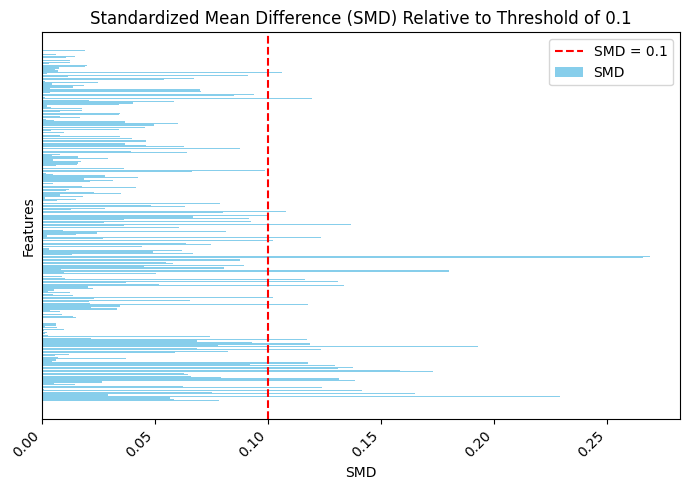

In [ ]:
plt.figure(figsize=(7, 5))
plt.barh(table1.smd_table.index, abs(table1.smd_table.values).flatten(), color='skyblue', label='SMD')

# SMD <= 0.1 is the convention for acceptable, like p-value <= 0.05
plt.axvline(x=0.1, color='r', linestyle='--', label='SMD = 0.1')
plt.xlabel('SMD')
plt.ylabel('Features')
# remove the y labels
plt.yticks([])
plt.title('Standardized Mean Difference (SMD) Relative to Threshold of 0.1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
print(table1.smd_table.loc[table1.smd_table.abs().sort_values(by='SMD (0,1)', ascending=False).head(10).index])

              SMD (0,1)
variable               
MBSTATE_REC_2  0.269057
MBSTATE_REC_1  0.266205
FAGECOMB       0.229192
COMBGEST        0.19315
MEDUC_3        0.180423
MHTR           0.173158
RF_GDIAB       0.165377
WTGAIN         0.158479
RF_GHYPE       0.141893
PRECARE        0.138829


####  Confidence Intervals

This is just one example of creating confidence intervals to give you a feel \
This example is not canonical

In [ ]:
bootstrap_sample_size = 50
alpha = 0.05
np.random.seed(42)
att_estimates = []
# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    print(f'Starting iter {i}')
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(standardized_data.index,
                                         size=standardized_data.shape[0],
                                         replace=True)
    bootstrap_standardized_data = standardized_data.loc[bootstrap_indices]
    standardized_data_treat1 = bootstrap_standardized_data.query('T == 1').reset_index().drop(columns=['index'])
    standardized_data_treat0 = bootstrap_standardized_data.query('T == 0').reset_index().drop(columns=['index'])
    nn = NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=1)
    distance, standardized_data_treat1['matched_treat0'] = nn.fit(standardized_data_treat0[confounders]).kneighbors(standardized_data_treat1[confounders])
    matched_data = standardized_data_treat1.merge(standardized_data_treat0, left_on='matched_treat0', right_index=True, how='left', suffixes=('_treat1', '_treat0'))
    att_estimate = np.mean(matched_data['Y_treat1'] - matched_data['Y_treat0'])
    att_estimates.append(att_estimate)

matching_bootstrap_estimates = np.array(att_estimates)

matching_ci = np.percentile(matching_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

Starting iter 0
Starting iter 1
Starting iter 2
Starting iter 3
Starting iter 4
Starting iter 5
Starting iter 6
Starting iter 7
Starting iter 8
Starting iter 9
Starting iter 10
Starting iter 11
Starting iter 12
Starting iter 13
Starting iter 14
Starting iter 15
Starting iter 16
Starting iter 17
Starting iter 18
Starting iter 19
Starting iter 20
Starting iter 21
Starting iter 22
Starting iter 23
Starting iter 24
Starting iter 25
Starting iter 26
Starting iter 27
Starting iter 28
Starting iter 29
Starting iter 30
Starting iter 31
Starting iter 32
Starting iter 33
Starting iter 34
Starting iter 35
Starting iter 36
Starting iter 37
Starting iter 38
Starting iter 39
Starting iter 40
Starting iter 41
Starting iter 42
Starting iter 43
Starting iter 44
Starting iter 45
Starting iter 46
Starting iter 47
Starting iter 48
Starting iter 49
95% Confidence Interval: Lower = -0.026075920981041615, Upper = -0.017164121036801937


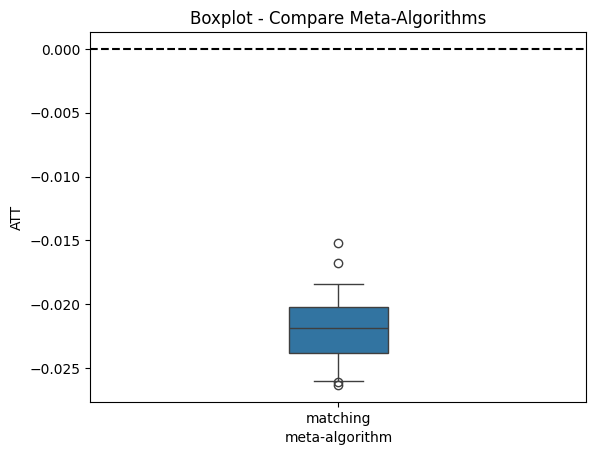

In [ ]:
df = pd.DataFrame({'matching': matching_bootstrap_estimates}).melt()
df.columns = ['meta-algorithm', 'ATT']
sns.boxplot(x='meta-algorithm', y='ATT', data=df, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

In [ ]:
import json
with open('matching_bootstrap_estimates.json', 'w') as f:
    json.dump(matching_bootstrap_estimates.tolist(), f)

In [48]:
print(table1.smd_table.columns)

Index(['SMD (0,1)'], dtype='object')
